In [29]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from numpy import log as ln
import sys 
sys.path.append("/home/bruce1996/data/Yi-Fung-Chuang/")
from microbiome_preprocessing import split_tax,filter_taxa_by_prevalence,taxa_prevalence,relative_abundance,add_taxa_name,binary_anomaly_detection_scatter_plot
from GMHI import GMHI,grid_search_for_gmhi

## MCI cohort

In [2]:
mci_taxtable = pd.read_csv("/home/bruce1996/data/Yi-Fung-Chuang/MCI/mci_taxtable.txt",sep = "\t",index_col = 0)
mci_otutable =pd.read_csv("/home/bruce1996/data/Yi-Fung-Chuang/MCI/mci_otutable.txt",sep = "\t",index_col = 0)
demographic = pd.read_csv("/home/bruce1996/data/Yi-Fung-Chuang/MCI/demographic.txt",sep = "\t",index_col = 0)

In [3]:
mci_taxtable = mci_taxtable.drop("sp3866")
mci_otutable = mci_otutable.drop("sp3866")
tt = add_taxa_name(mci_otutable,mci_taxtable)
mci_otutable.index = tt
mci_taxtable.index = tt
mci_otutable = relative_abundance(mci_otutable)
mci_otu,mci_tax = filter_taxa_by_prevalence(mci_otutable,mci_taxtable,1)

demographic =  demographic.sort_values(["MCI"])
sorted_idx = list(demographic.index)
mci_otu = mci_otu.reindex(columns = sorted_idx)

In [ ]:
#grid search for GMHI parameter (prevalence)
pre_fold_t = [1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]
pre_diff_t = [5,10,15,20]
mci_gmhi_df = grid_search_for_gmhi(mci_otu,demographic,"MCI",[0,1],
pre_diff_threshold=pre_diff_t,
pre_fold_threshold=pre_fold_t,
abundance_threshold=(10 ** -6))

In [4]:
#grid search for GMHI parameter (abundance)
pre_fold_t = [1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]
pre_diff_t = [0.1,0.2,0,3,0.4,0.5,0.6,0.7,0.8]
mci_gmhi_df = grid_search_for_gmhi(mci_otu,demographic,"MCI",[0,1],
diff_threshold=pre_diff_t,
fold_threshold=pre_fold_t,
use_prevalence = False,
abundance_threshold=(10 ** -6))

In [8]:
mci_gmhi_df = mci_gmhi_df.sort_values(by = ['Accuracy'],ascending=False)
mci_gmhi_df.to_csv('/home/bruce1996/data/Yi-Fung-Chuang/MCI/mci_gmhi_by_ab_performance.csv',index=False)

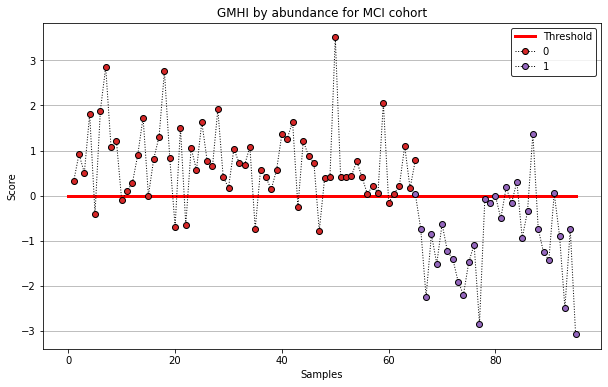

In [12]:
mci_gmhi_ab,_,_ = GMHI(mci_otu,demographic,"MCI",[0,1],
                diff_threshold=0.2,
                fold_threshold=1.3,
                use_prevalence=False,
                 abundance_threshold=(10 ** -6) )

binary_anomaly_detection_scatter_plot(0,mci_gmhi_ab,demographic["MCI"].values,[0,1],"one_class_classification/mci_gmhi_ab.png","GMHI by abundance for MCI cohort")


## AVCD cohort

In [2]:
path = "/home/bruce1996/data/Yi-Fung-Chuang/GMHI/mpa/merge_sample.mpa"
ab_table,tax_table = split_tax(path)
ab_table = ab_table.drop("NCBI_tax_id",1)
otu_table,tax_table = filter_taxa_by_prevalence(ab_table,tax_table,1)

avcd_label = pd.read_csv("/data/bruce/GMHI/PRJEB21528/sample_label.txt",sep = "\t",header=None,index_col = 0)
avcd_label.columns = ["Status"]
avcd_label = avcd_label.sort_values(["Status"])
sorted_idx = list(avcd_label.index)
avcd_otu = otu_table.reindex(columns = sorted_idx)

In [7]:
avcd_gmhi,_,_ = GMHI(avcd_otu,avcd_label,"Status",["Healthy","Non-healthy"] )

In [ ]:
pre_fold_t = [1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]
pre_diff_t = [5,10,15,20]
gmhi_df = grid_search_for_gmhi(avcd_otu,avcd_label,"Status",["Healthy","Non-healthy"],
pre_diff_threshold=pre_diff_t,
pre_fold_threshold=pre_fold_t,
abundance_threshold=(10 ** -6))

In [16]:
#grid search for GMHI parameter (abundance)
fold_t = [1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]
diff_t = [0.1,0.2,0,3,0.4,0.5,0.6,0.7,0.8]
avcd_gmhi_df = grid_search_for_gmhi(avcd_otu,avcd_label,"Status",["Healthy","Non-healthy"],
diff_threshold=diff_t,
fold_threshold=fold_t,
use_prevalence = False,
abundance_threshold=(10 ** -6))

In [20]:
avcd_gmhi_df = avcd_gmhi_df.sort_values(by = ['Accuracy'],ascending=False)
avcd_gmhi_df.to_csv('/home/bruce1996/data/Yi-Fung-Chuang/avcd_gmhi_ab_performance.csv',index=False)

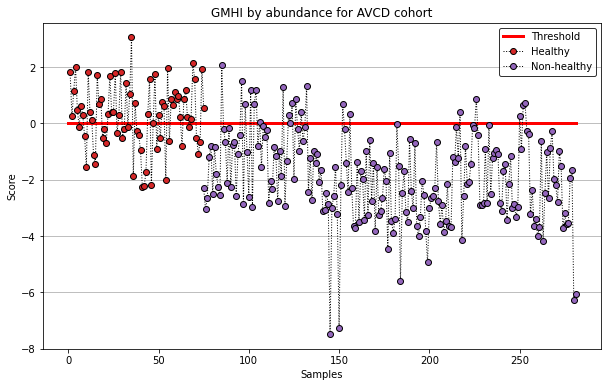

In [8]:
avcd_gmhi,_,_ = GMHI(avcd_otu,avcd_label,"Status",["Healthy","Non-healthy"],
                diff_threshold=0.1,
                fold_threshold=1.9,
                use_prevalence=False,
                abundance_threshold=(10 ** -6) )

binary_anomaly_detection_scatter_plot(0,avcd_gmhi,avcd_label["Status"].values,["Healthy","Non-healthy"],"one_class_classification/avcd_gmhi_ab.png","GMHI by abundance for AVCD cohort")

## Our cohort

In [2]:
path = "/home/bruce1996/data/Yi-Fung-Chuang/fastq/centrifuge_output/merge_mpa_report.txt"
ab_table,tax_table = split_tax(path)
otu_table = relative_abundance(ab_table)
otu_table,tax_table = filter_taxa_by_prevalence(otu_table,tax_table,1)

In [17]:
health_prevent =pd.read_csv("/home/bruce1996/data/Yi-Fung-Chuang/GMHI/probiotics.txt",sep=',')
health_scarce = pd.read_csv("/home/bruce1996/data/Yi-Fung-Chuang/GMHI/health_scarce.txt")

header = 's__'
for i in range(health_prevent.shape[0]) :
    health_prevent.iloc[i] = header + health_prevent.iloc[i]
for i in range(health_scarce.shape[0]) :
    health_scarce.iloc[i] = header + health_scarce.iloc[i]

health_pre = list(health_prevent['Species'].values)
health_scarce = list(health_scarce['Species'].values)


In [18]:
idx = list(otu_table.index)
health_species = list()
nohealth_species =list()
for i in range(len(health_pre)) :
    pattern = health_pre[i] + '*.'
    rh = re.compile(pattern)
    newlist = list(filter(rh.match, idx))
    health_species = health_species + newlist

for i in range(len(health_scarce)) :
    pattern = health_scarce[i]+'*.'
    rn = re.compile(pattern)
    newlist = list(filter(rn.match, idx))
    nohealth_species = nohealth_species + newlist

['s__Lactobacillus_helveticus',
 's__Levilactobacillus_brevis',
 's__Faecalibacterium_prausnitzii']

In [24]:
mh_df = otu_table.loc[health_species,:]
mn_df = otu_table.loc[nohealth_species,:]

In [30]:
health_pre = taxa_prevalence(mh_df)
nohealth_pre = taxa_prevalence(mn_df)
prevalence = health_pre + nohealth_pre

In [31]:
target_species_df = mh_df.append(mn_df)
mean_abundance = target_species_df.mean(axis = 1)
idx = list(target_species_df.index)
label = ['Health-prevalent'] * mh_df.shape[0] + ['Helath-scarce'] * mn_df.shape[0]
tmp = {'Species' : idx,'Abundance' : mean_abundance,'Prevalence' : prevalence,'Class' :label}
df = pd.DataFrame(tmp)

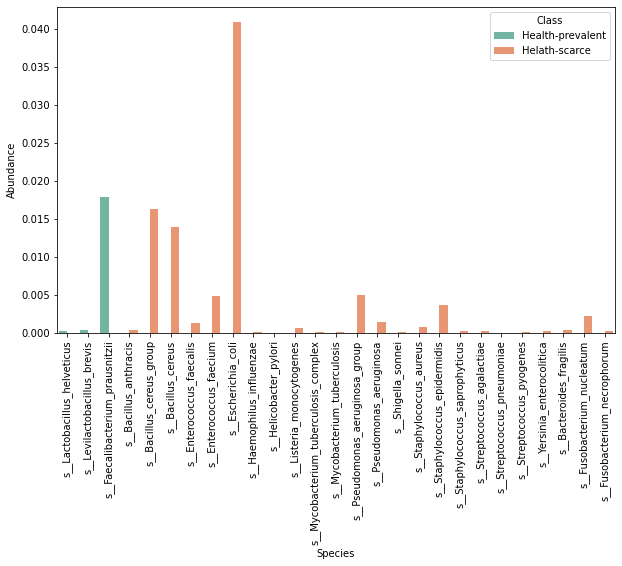

In [36]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x="Species", y="Abundance",hue='Class' ,data=df, palette="Set2")
plt.xticks(rotation=90)
plt.savefig('tmp/Target_species_abundance.png',dpi = 300,bbox_inches="tight")

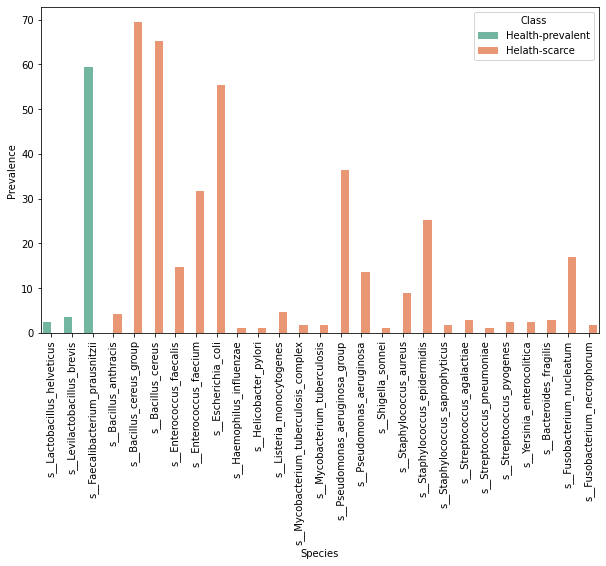

In [37]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Species", y="Prevalence",hue='Class' ,data=df, palette="Set2")
plt.xticks(rotation=90)
plt.savefig('tmp/Target_species_prevalence.png',dpi = 300,bbox_inches="tight")

In [41]:
gmhi_tw,_,_ = GMHI(otu_table,df,"Species",[0,1],
                diff_threshold=0.2,
                fold_threshold=1.3,
                target_species=True,
                health_species=health_species,
                nohealth_species=nohealth_species,
                 abundance_threshold=(10 ** -6) )

In [42]:
def ocgmhi_plot(threshold,score,label,path,title):
        """ 
        DESCRIPTION
        Plot the curve of distance
        --------------------------------------------------------------- 

        """ 
        n = len(score)
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(1, 1, 1)
        radius = np.ones((n, 1)) * threshold
        x1 = np.arange(1,n+1)

        ax.plot(radius, 
                color='r',
                linestyle='-', 
                marker='None',
                linewidth=3, 
                markeredgecolor='k',
                markerfacecolor='w', 
                markersize=6)
    
        ax.plot(x1,score,
                color='k',
                linestyle=':',
                marker='o',
                linewidth=1,
                markeredgecolor='k',
                markerfacecolor='C3',
                markersize=6,
                label = label)

        ax.legend(["Threshold",label ], 
                ncol=1, loc=0, 
                edgecolor='black', 
                markerscale=1, fancybox=True)
        
        ax.set_xlabel('Samples')
        ax.set_ylabel('GMHI Score')
        plt.title(title)
        
        ax.yaxis.grid()
        plt.savefig(path,dpi = 300)
        plt.show()

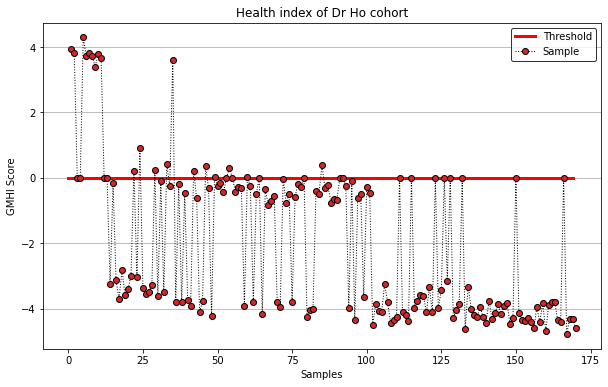

In [43]:
ocgmhi_plot(0,gmhi_tw,'Sample','tmp/gmhi_score_of_dr_ho.png','Health index of Dr Ho cohort')